In [1]:
## popular python packages
import numpy as np
import matplotlib.pyplot as plt
from dask_quantumtinkerer import Cluster, cluster_options
from dask.distributed import wait, as_completed
import tinyarray as ta
from itertools import product

# packages used here
import kwant

import sys, os

# pre-defined functions
sys.path.append(os.path.realpath('./../code/'))
from optimization import Optimize, optimize_phase, optimize_voltage
import parameters
from constants import scale, majorana_pair_indices
from utils import voltage_dict, eigsh, svd_transformation, hamiltonian
from parallel import parameter_tuning

sys.path.append(os.path.realpath('./../spin-qubit/'))

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [3]:
def return_couplings(x):
    data = []
    for res in x:
        data.append(np.max(np.array(res[1]), axis = 0))
    return np.array(data)

In [2]:
import pickle
SAVE_AT = "/home/tinkerer/trijunction-design/data/results/"
# filename = SAVE_AT + "results_2508.pkl"
# with open(filename, "rb") as outfile:
#     result = pickle.load(outfile)
    
# couplings_25 = return_couplings(result)
    
filename = SAVE_AT + "results_2608.pkl"
with open(filename, "rb") as outfile:
    result = pickle.load(outfile)
    
# couplings_26 = return_couplings(result)

In [3]:
import json
with open("/home/tinkerer/trijunction-design/code/config.json", "r") as outfile:
    config = json.load(outfile)

In [4]:
%%time

optimize = Optimize(
    config, poisson_system=[], linear_problem=[], boundaries=[], scale=scale
)

# thickness, gap = newconfig

change_config = [
    {"device": {"thickness": {"dielectric": 1.0}}},
    {"gate": {"channel_width": 13.0, 'angle': np.pi/6, 'gap': 2}},
]

_, boundaries, poisson_system, linear_problem = optimize.changeconfig(change_config)

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
Finding linear part of the tight-binding Hamiltonian


100%|██████████| 13/13 [00:33<00:00,  2.61s/it]


CPU times: user 2min 40s, sys: 8.89 s, total: 2min 49s
Wall time: 2min 49s


In [5]:
voltages, phase = result[6][2:]

In [17]:
from potential import gate_potential


pot = gate_potential(
    optimize.poisson_system,
    optimize.linear_problem,
    optimize.site_coords[:, [0, 1]],
    optimize.site_indices,
    voltage_dict(optimal_voltages['left-right'].x, True),
    {},
    offset=optimize.offset[[0, 1]],
)


# pot = dict(zip(ta.array(optimize.site_coords[:, [0, 1]]), 
#                      np.zeros(len(optimize.site_coords))))

params.update(potential=pot)

# params.update(phase['left-right'])

poisson_sites = np.array(list(pot.keys()))
kwant_sites = np.array([site.pos for site in optimize.trijunction.sites])


In [18]:
kwant_params = optimize.f_params(**params)

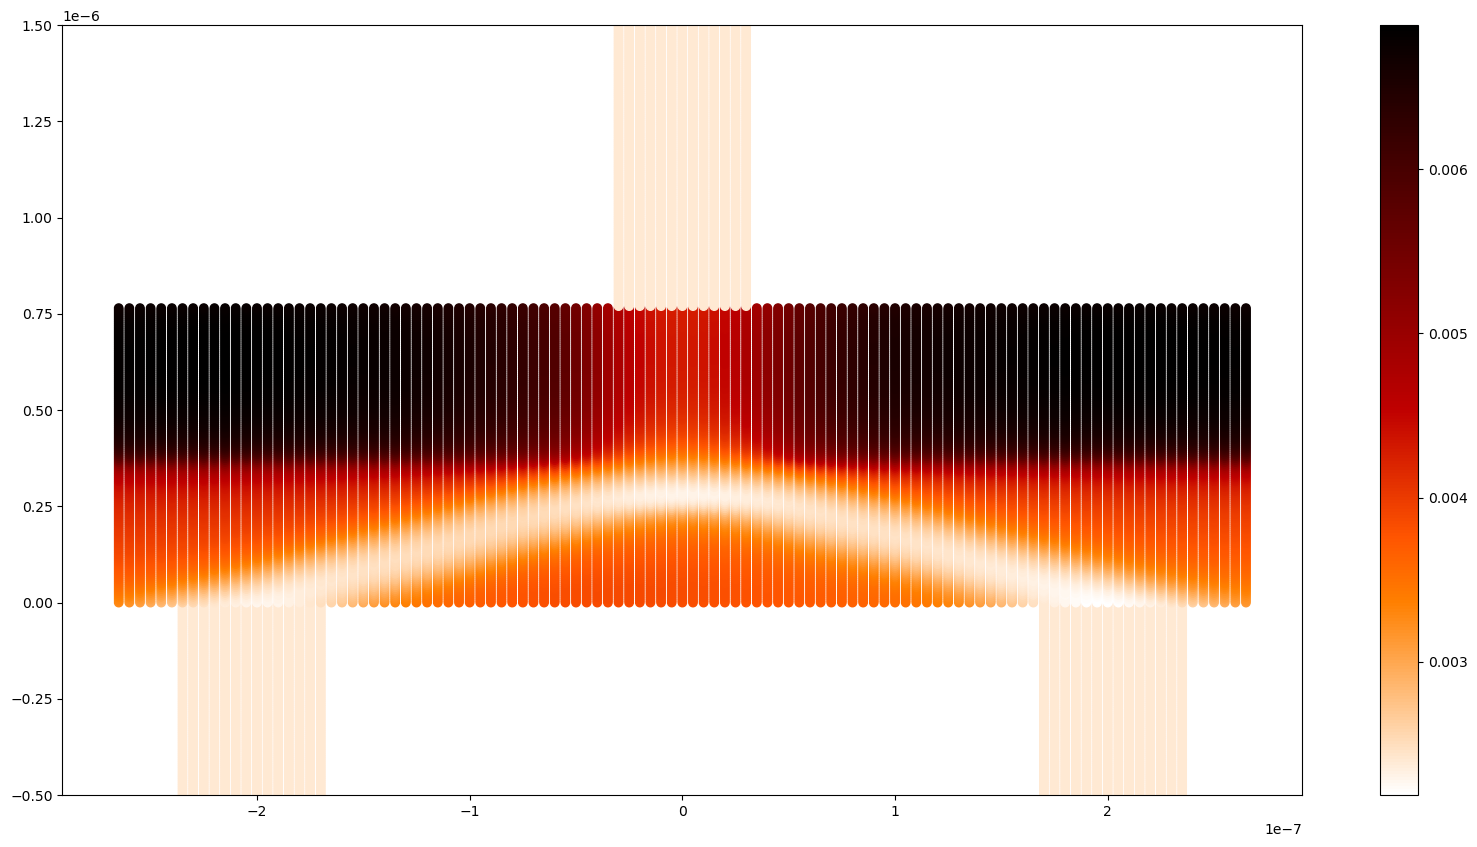

In [19]:
plt.figure(figsize=(20, 10))
def diff_pot(x, y):
    return kwant_params['mu'](x, y)

to_check = [diff_pot(*site) for site in kwant_sites]

plt.scatter(kwant_sites[:, 0], kwant_sites[:, 1], c = to_check, cmap = 'gist_heat_r')
plt.ylim(-0.5e-6, 1.5e-6);
plt.colorbar();

In [50]:
mu = parameters.bands[0]
from optimization import dep_acc_regions, potential_shape_loss

dep_points, acc_points = utils.dep_acc_regions(
            optimize.poisson_system, optimize.site_indices, optimize.nw_centers, 'left-right'
        )
x = [0.004, 0.004, 0.004, 0.0023]

potential, potential_loss = potential_shape_loss(
    x,
    optimize.poisson_system,
    optimize.optimizer_args['poisson_params'],
    mu,
    dep_points,
    acc_points
)

In [5]:
from utils import dep_acc_regions
dep_points, acc_points = dep_acc_regions(
    optimize.poisson_system, optimize.site_indices, optimize.nw_centers, 'left-right'
)

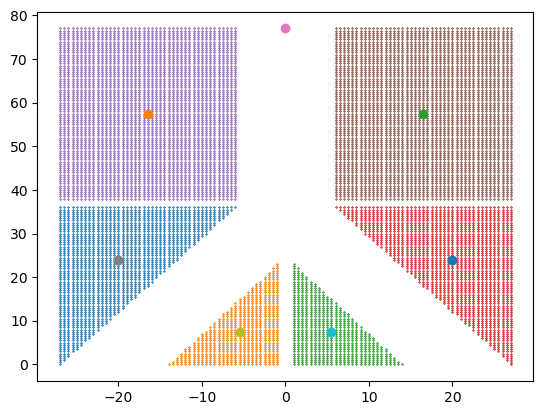

In [6]:
grid = optimize.poisson_system.grid.points
twodeg_grid = optimize.site_coords
for gate, indices in optimize.poisson_system.regions.voltage.tag_points.items():
    g = grid[indices]
    if gate.split('_')[0] not in ['global', 'dirichlet']:
        plt.scatter(g[:, 0], g[:, 1], s = 0.1, alpha = 1)

for _, indices in dep_points.items():
    point = optimize.site_coords[indices[0]]
    plt.scatter(point[0], point[1])

In [13]:
phase = optimal_phase['left-right']

In [125]:
voltage = [0.5, 0.5, 0.5, 0.5]

In [20]:
mu = parameters.bands[0]
params = parameters.junction_parameters(m_nw=[mu, mu, mu])

In [21]:
potential = dict(zip(ta.array(optimize.site_coords[:, [0, 1]]), 
                     np.zeros(len(optimize.site_coords))))
params.update(potential=potential)

params.update(optimal_phase['left-right'])

kwant_params = {**params, **optimize.optimizer_args['linear_terms']}

numerical_hamiltonian = hamiltonian(
        optimize.trijunction, 
        voltage_dict(optimal_voltages['left-right'].x, True),
        optimize.f_params, **kwant_params
    )

In [22]:
from constants import majorana_pair_indices
pair_indices = majorana_pair_indices['left-right'].copy()

pair_indices.append(list(set(range(3)) - set(pair_indices))[0])
shuffle = pair_indices + [-3, -2, -1]
desired_order = np.array(list(range(2, 5)) + list(range(2)) + [5])[shuffle]

reference_wave_functions = optimize.mlwf[desired_order]

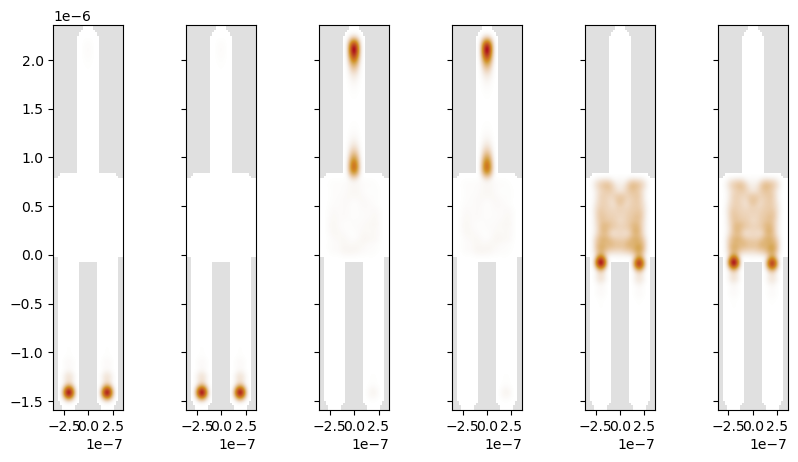

In [23]:
from utils import eigsh
import scipy.sparse.linalg as sla
energies, wave_functions = sla.eigsh(numerical_hamiltonian.tocsc(),
                                   len(reference_wave_functions),
                                   sigma=0,
                                   return_eigenvectors=True
                                  )

# energies, wave_functions = eigsh(
#     numerical_hamiltonian.tocsc(),
#     len(reference_wave_functions),
#     sigma=0,
#     return_eigenvectors=True,
# )

fig, ax = plt.subplots(1, len(wave_functions.T), figsize = (10, 5), sharey= True)

density = kwant.operator.Density(optimize.trijunction, np.eye(4))
for i, vec in enumerate(wave_functions.T):
    kwant.plotter.density(optimize.trijunction, 
                          density(vec), 
                          ax = ax[i]
                         );
    

In [24]:
transformed_hamiltonian = (
    svd_transformation(energies, 
                       wave_functions, 
                       reference_wave_functions)
)

desired = np.abs(transformed_hamiltonian[0, 1])

In [25]:
from sympy import Matrix

In [26]:
Matrix(transformed_hamiltonian/optimize.topological_gap)

Matrix([
[                         2.0071897528028e-10,    0.0221176869108262 - 5.98941862348012e-5*I, -5.91541744171826e-7 - 3.83540183910507e-7*I,  -6.11533539544274e-5 + 1.1444551517546e-8*I,   6.10741101268962e-7 + 6.8290136877945e-7*I,  -2.8046762705259e-6 + 1.35839457637585e-6*I],
[  0.0221176869108262 + 5.98941862348012e-5*I, -2.0071864632993e-10 - 3.97763422406221e-19*I,  1.42298540600964e-6 - 2.18173353110373e-6*I, -1.07490957205188e-6 - 9.34698551330335e-5*I, -7.91268791397818e-5 - 4.66926318091288e-5*I,  6.15259241540988e-7 + 1.27914327401931e-6*I],
[-5.91541744171826e-7 + 3.83540183910507e-7*I,   1.42298540600964e-6 + 2.18173353110373e-6*I,                         3.79638539644964e-15,  1.31148840632043e-6 + 2.25595490497494e-6*I, -8.87418850458693e-6 + 2.31200015328096e-7*I,  4.67842417774818e-5 + 2.83327490615526e-5*I],
[-6.11533539544273e-5 - 1.14445515175367e-8*I,  -1.07490957205188e-6 + 9.34698551330334e-5*I,  1.31148840632043e-6 - 2.25595490497494e-6*I,               

In [27]:
from utils import voltage_dict
from collections import OrderedDict

voltages = {}
mu = np.round(parameters.bands[0], 4)
initial_condition = OrderedDict()
for i, pair in enumerate(['left-top', 'right-top', 'left-right']):
    initial = [-3.0e-3, -3.0e-3, -3.0e-3, 3e-3]
    # initial[i] = -mu * 10
    voltages[pair] = voltage_dict(initial, True)
    initial_condition[pair] = initial.copy()
del initial_condition['left-top']
del initial_condition['right-top']

In [10]:
import optimization
import importlib
importlib.reload(optimization)

<module 'optimization' from '/home/tinkerer/trijunction-design/code/optimization.py'>

In [11]:
kwant_params = {
    "kwant_sys": optimize.trijunction,
    "kwant_params_fn": optimize.f_params,
    "general_params": params,
    "linear_terms": optimize.optimizer_args["linear_terms"],
}

zero_potential = dict(
    zip(
        ta.array(optimize.site_coords[:, [0, 1]] - optimize.offset),
        np.zeros(len(optimize.site_coords)),
    )
    )

kwant_params["general_params"].update(potential=zero_potential)
optimal_phase = optimization.optimize_phase(
           [voltages['left-right']], ['left-right'], kwant_params, 10
        )

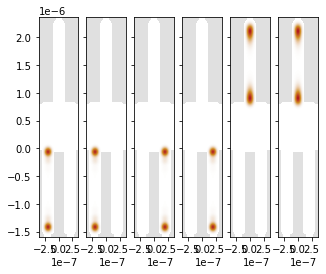

In [30]:
optimize.plot('DECOUPLED')

In [15]:
initial_condition

OrderedDict([('left-right', [-0.003, -0.003, -0.003, 0.003])])

In [16]:
from optimization import optimize_voltage
optimize.optimizer_args['nw_centers'] = optimize.nw_centers
optimal_voltages = optimization.optimize_voltage(
            ['left-right'],
            [initial_condition['left-right']],
            [optimal_phase['left-right']],
            optimize.optimizer_args,
            optimize.topological_gap,
        )

Optimizing pair left-right
0.04075022440656043
0.04075025971085777
0.04075025971085777
0.04075026550223866
0.040750231802704984
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | +4.1016e-02 | 1.00e-03 | 2.76e+00 | 0.00e+00 |
0.03638229586874728
0.036382331173044624
0.036382331173044624
0.0363823369644255
0.036382303264891835
|   2   |  10   |   1   | +3.6648e-02 | 7.00e-03 | 2.76e+00 | 0.00e+00 |
0.005806796104055231
0.005806760799757888
0.005806760799757888
0.005806755008377008
0.00580680350019978
|   3   |  15   |   2   | +6.0730e-03 | 4.90e-02 | 2.76e+00 | 0.00e+00 |
0.028268736334100826
0.028268745555947387
0.02826874555594739
0.02826873680671815
0.028268725448088883
|   4   |  20   |   3   | +6.0730e-03 | 2.45e-02 | 2.76e+00 | 0.00e+00 |
0.013363499448941227
0.013363508670787784
0.013363508670787793
0.013363499921558547
0.013363488562929283
|   5   |  25   |   

# Y-shaped geometry

#### Parameters

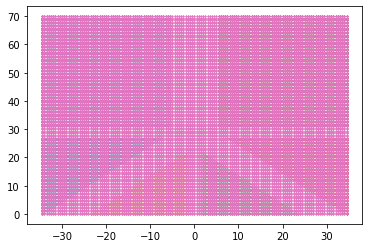

In [9]:
optimize.plot('GATES')

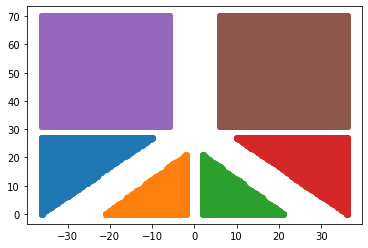

In [10]:
for gate, indices in optimize.poisson_system.regions.voltage.tag_points.items():
    g = grid[indices]
    if gate.split('_')[0] not in ['global', 'dirichlet']:
        plt.scatter(g[:, 0], g[:, 1])

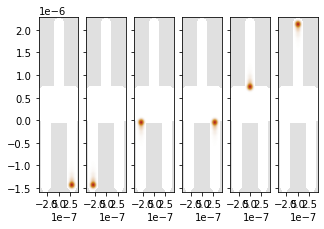

In [57]:
optimize.plot('WANNIER_FUNCTIONS')

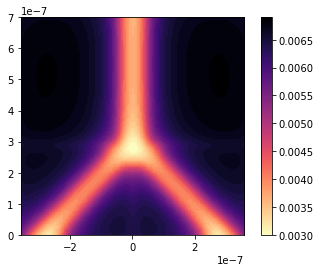

In [11]:
optimize.plot('POTENTIAL')

In [30]:
from collections import OrderedDict
pairs = ['right-top', 'left-top', 'left-right']
voltages = OrderedDict()
initial_condition = OrderedDict()
for i, pair in enumerate(pairs):
    initial = [-1.5e-3, -1.5e-3, -1.5e-3, 3e-3]
    initial[i] = -3.5e-3
    voltages[pair] = voltage_dict(initial, True)
    initial_condition[pair] = initial.copy()

In [31]:
poisson_params = {'poisson_system': poisson_system,
                  'linear_problem': linear_problem,
                  'site_coords': optimize.site_coords,
                  'site_indices': optimize.site_indices,
                  'offset': optimize.offset
                 }
params = parameters.junction_parameters(m_nw=parameters.bands[0] * np.ones(3))

kwant_params = {'kwant_sys': optimize.trijunction,
                'kwant_params_fn': optimize.f_params,
                'general_params': params,
                'linear_terms': optimize.optimizer_args['linear_terms']}

In [32]:
zero_potential = dict(zip(ta.array(optimize.site_coords[:, [0, 1]]), np.zeros(len(optimize.site_coords))))

kwant_params['general_params'].update(potential=zero_potential)

In [33]:
def wave_functions_coupling(pair, 
                      optimal_phase, 
                      voltages, 
                      kwant_system, 
                      kwant_params, 
                      kwant_params_fn, 
                      linear_terms, 
                      mlwf,
                      energy_scale):
   
    kwant_params.update(optimal_phase)
    
    if not isinstance(voltages, dict): 
        voltages = voltage_dict(voltages, True)

    params = {**kwant_params, **linear_terms}
    
    
    numerical_hamiltonian = hamiltonian(kwant_system, 
                                        voltages, 
                                        kwant_params_fn, 
                                        **params
                                       )
    
    energies, wave_functions = eigsh(
        numerical_hamiltonian.tocsc(),
        6,
        sigma=0,
        return_eigenvectors=True
    )
    
    pair_indices = majorana_pair_indices[pair].copy()
    pair_indices.append(list(set(range(3)) - set(pair_indices))[0])
    shuffle = pair_indices + [-3, -2, -1]
    desired_order = np.array(list(range(2, 5)) + list(range(2)) + [5])[shuffle]
    
    
    reference_wave_functions = mlwf[desired_order]
    
    transformed_hamiltonian = svd_transformation(
        energies,
        wave_functions,
        reference_wave_functions
    )/energy_scale
    
    coupled = np.abs(transformed_hamiltonian[0, 1])
    uncoupled = np.abs([transformed_hamiltonian[1, 2], transformed_hamiltonian[2, 3]])

    
    return wave_functions, coupled, uncoupled



In [34]:
%%time

intermediate_couplings = []

iteration = 0
tol = 1e-1
max_tol = 1e-2

voltages = [voltages[pair] for pair in [pairs[0], pairs[2]]]

del initial_condition['left-top']

while np.any(tol > max_tol):

    optimal_phases = optimize_phase_fn(voltages, 
                                       [pairs[0], pairs[2]], 
                                       kwant_params, 
                                       10)
    
    # A = datetime.datetime.now()
    optimal_voltages = optimization.optimize_gate_fn([pairs[0], pairs[2]], 
                                         initial_condition, 
                                         optimal_phases,
                                        optimize.optimizer_args,
                                        optimize.topological_gap
                                        )
    # B = datetime.datetime.now()
    # print(f'Optimization took {B - A}')
    
    voltages = [voltage_dict(optimal_voltages[pair].x, 
                             True) for pair in [pairs[0], 
                                                pairs[2]]]
    for pair in [pairs[0], pairs[2]]: 
        initial_condition[pair] = optimal_voltages[pair].x


    couplings = {}
    for voltage, pair in zip(voltages, [pairs[0], 
                                        pairs[2]]):
        _, coupling, _ = wave_functions_coupling(pair, 
                                                 optimal_phases[pair], 
                                                 voltage, 
                                                 optimize.trijunction, 
                                                 kwant_params['general_params'], 
                                                 optimize.f_params, 
                                                 optimize.optimizer_args['linear_terms'], 
                                                 optimize.mlwf,
                                                 optimize.topological_gap
                             )
        couplings[pair] = coupling
    
    intermediate_couplings.append(np.array(list(couplings.values())))

    if iteration > 1: tol = np.diff(intermediate_couplings[-2:], axis = 0)
    
    iteration += 1

Optimizing pair right-top
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | -3.0728e+00 | 1.00e-04 | 1.21e+03 | 0.00e+00 |
|   2   |  10   |   1   | -3.1800e+00 | 2.00e-04 | 7.74e+02 | 0.00e+00 |
|   3   |  15   |   2   | -3.2999e+00 | 1.40e-03 | 3.00e+02 | 0.00e+00 |
|   4   |  20   |   4   | -3.3882e+00 | 1.56e-03 | 3.66e+02 | 0.00e+00 |
|   5   |  25   |   7   | -3.3882e+00 | 7.79e-04 | 3.66e+02 | 0.00e+00 |
|   6   |  30   |   9   | -3.3882e+00 | 3.89e-04 | 3.66e+02 | 0.00e+00 |
|   7   |  35   |  11   | -3.3882e+00 | 1.95e-04 | 3.66e+02 | 0.00e+00 |
|   8   |  40   |  13   | -3.4594e+00 | 1.36e-03 | 4.87e+02 | 0.00e+00 |
|   9   |  45   |  17   | -3.4594e+00 | 1.36e-04 | 4.87e+02 | 0.00e+00 |
|  10   |  50   |  18   | -3.4594e+00 | 2.67e-05 | 4.87e+02 | 0.00e+00 |
|  11   |  55   |  19   | -3.4770e+00 | 1.87e-04 | 5.26e+02 | 0.00e+00 |
|  12   |  60   |  20   |

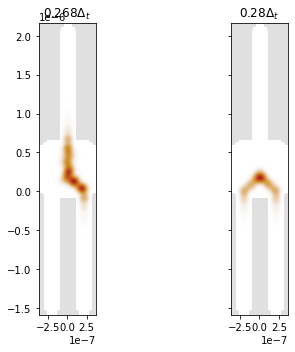

In [199]:
sfig, ax = plt.subplots(1, 2, figsize = (10, 5), sharey= True)

for i, pair in enumerate([pairs[0], pairs[2]]):
    wave_functions, coupling, _ = wave_functions_coupling(pair, 
                                                  optimal_phases[pair], 
                                                  optimal_voltages[pair].x, 
                                                  optimize.trijunction, 
                                                  kwant_params['general_params'], 
                                                  optimize.f_params, 
                                                  optimize.optimizer_args['linear_terms'], 
                                                  optimize.mlwf,
                                                  optimize.topological_gap
                     )


    kwant.plotter.density(optimize.trijunction, optimize.densityoperator(wave_functions[:, -1]), ax = ax[i]);
    ax[i].set_title(f'{np.round(coupling, 3)}'+r'$\Delta_t$');
    plt.tight_layout()

In [212]:
pair = pairs[2]
optimization_args = [optimize.site_coords, 
                     optimize.trijunction, optimize.f_params,
                     optimize.optimizer_args['linear_terms'], 
                     optimize.mlwf, optimal_phases[pair],
                    pair, optimize.topological_gap]

# Parallel simulation

In [ ]:
def optimize_thickness_gap(newconfig):
        
    
    return solver


In [ ]:
cluster_dashboard_link = "http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/"

with Cluster(options) as cluster:
    cluster.scale(n=len(sequence))
    client = cluster.get_client()
    print(cluster_dashboard_link + cluster.dashboard_link[17:])
    solver = optimize_thickness_gap()
    results = []
    futures = client.map(optimize_thickness_gap(), sequence)
    for future in futures:
        if future.status == 'error':
            print('Error!')
            results.append('E')
        else:
            results.append(future.result())

http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/8000/clusters/8533abbea10048429485c2c7d9afcd3c/status


In [201]:
def test_parallel(i):
    if i == 2: print(a)
    return i

In [205]:
with Cluster(options) as cluster:
    cluster.scale(n=5)
    client = cluster.get_client()
    print(cluster_dashboard_link + cluster.dashboard_link[17:])
    futures = client.map(test_parallel, range(5))
    for future in futures:
        if future.status == 'error':
            print('Error!')
        else:
            print(future.result())

http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/8000/clusters/7fe1bde7fbe64a7aac85c0fee78b119c/status
0
1
Error encountered!
3
4
